# Keras Custom callback 

This is a notebook for the medium article [Building Custom Callbacks with Keras and TensorFlow 2](https://bindichen.medium.com/building-custom-callbacks-with-keras-and-tensorflow-2-85e1b79915a3)

Please check out article for instructions

**License**: [BSD 2-Clause](https://opensource.org/licenses/BSD-2-Clause)

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt

### Helper function to plot metric

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [3]:
def plot_lr(history):
    learning_rate = history.history['lr']
    epochs = range(1, len(learning_rate) + 1)
    plt.plot(epochs, learning_rate)
    plt.title('Learning rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning rate')
    plt.show()

## Fashion MNIST dataset

In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [5]:
X_train_full.shape

(60000, 28, 28)

In [6]:
X_train_full.dtype

dtype('uint8')

In [7]:
X_test.shape

(10000, 28, 28)

In [8]:
y_test.dtype

dtype('uint8')

In [9]:
# For faster training, let's use a subset 10,000
X_train, y_train = X_train_full[:10000] / 255.0, y_train_full[:10000]

## Building a NN model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

def create_model(): 
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(300, activation='relu'),
        Dense(100, activation='relu'),
        Dense(10, activation='softmax'),
    ])
    model.compile(
        optimizer='sgd', 
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )
    return model

In [11]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


## 1. Building a custom callback for training

In [12]:
from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
    
    def on_train_begin(self, logs=None):
        print("Starting training...")
        
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Starting epoch {epoch}")

    def on_train_batch_begin(self, batch, logs=None):
        print(f"Training: Starting batch {batch}")
        
    def on_train_batch_end(self, batch, logs=None):
        print(f"Training: Finished batch {batch}, loss is {logs['loss']}")
        
    def on_epoch_end(self, epoch, logs=None):
        print(f"Finished epoch {epoch}, loss is {logs['loss']}, accuracy is {logs['accuracy']}")
        
    def on_train_end(self, logs=None):
        print("Finished training")

In [13]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=2, 
    validation_split=0.20, 
    batch_size=4000, 
    verbose=2,
    callbacks=[TrainingCallback()]
)

Train on 8000 samples, validate on 2000 samples
Starting training...
Starting epoch 0
Epoch 1/2
Training: Starting batch 0
Training: Finished batch 0, loss is 2.4427168369293213
Training: Starting batch 1
Training: Finished batch 1, loss is 2.360092878341675
Finished epoch 0, loss is 2.401404857635498, accuracy is 0.1262499988079071
8000/8000 - 1s - loss: 2.4014 - accuracy: 0.1262 - val_loss: 2.3497 - val_accuracy: 0.1160
Starting epoch 1
Epoch 2/2
Training: Starting batch 0
Training: Finished batch 0, loss is 2.3291571140289307
Training: Starting batch 1
Training: Finished batch 1, loss is 2.291919469833374
Finished epoch 1, loss is 2.3105382919311523, accuracy is 0.1368750035762787
8000/8000 - 0s - loss: 2.3105 - accuracy: 0.1369 - val_loss: 2.2786 - val_accuracy: 0.1195
Finished training


## 2. Building a custom callback for testing

In [14]:
class TestingCallback(Callback):
    
    def on_test_begin(self, logs=None):
        print("Starting testing ...")
        
    def on_test_batch_begin(self, batch, logs=None):
        print(f"Testing: Starting batch {batch}")
    
    def on_test_batch_end(self, batch, logs=None):
        print(f"Testing: Finished batch {batch}")
        
    def on_test_end(self, logs=None):
        print("Finished testing")

In [15]:
model.evaluate(X_test, y_test, verbose=False, callbacks=[TestingCallback()], batch_size=2000)

Starting testing ...
Testing: Starting batch 0
Testing: Finished batch 0
Testing: Starting batch 1
Testing: Finished batch 1
Testing: Starting batch 2
Testing: Finished batch 2
Testing: Starting batch 3
Testing: Finished batch 3
Testing: Starting batch 4
Testing: Finished batch 4
Finished testing


[121.49524536132813, 0.1332]

## 3. Building a custom callback for prediction

In [16]:
class PredictionCallback(Callback):
    
    def on_predict_begin(self, logs=None):
        print("Starting prediction ...")
    
    def on_predict_batch_begin(self, batch, logs=None):
        print(f"Prediction: Starting batch {batch}")
        
    def on_predict_batch_end(self, batch, logs=None):
        print(f"Prediction: Finish batch {batch}")
    
    def on_predict_end(self, logs=None):
        print("Finished prediction")

In [17]:
model.predict(X_test, verbose=False, callbacks=[PredictionCallback()], batch_size=2000)

Starting prediction ...
Prediction: Starting batch 0
Prediction: Finish batch 0
Prediction: Starting batch 1
Prediction: Finish batch 1
Prediction: Starting batch 2
Prediction: Finish batch 2
Prediction: Starting batch 3
Prediction: Finish batch 3
Prediction: Starting batch 4
Prediction: Finish batch 4
Finished prediction


array([[0.0000000e+00, 1.7347565e-15, 0.0000000e+00, ..., 3.5985607e-01,
        3.0031477e-30, 0.0000000e+00],
       [0.0000000e+00, 3.6086992e-32, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 8.8086944e-38,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 1.4598069e-01, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [9.8251455e-33, 2.9541528e-19, 0.0000000e+00, ..., 7.0404289e-20,
        2.1887297e-38, 0.0000000e+00]], dtype=float32)

## 2. Examples of Keras callback applications
Reference: https://keras.io/guides/writing_your_own_callbacks/

### 2.1 Real-time plot 

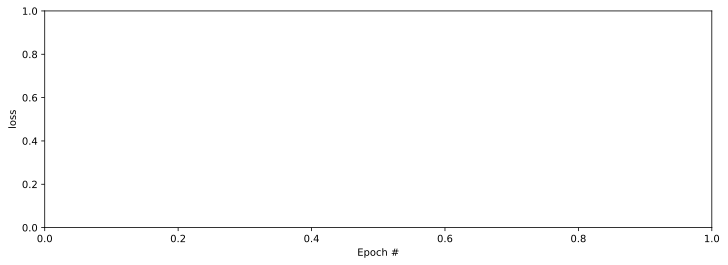

In [18]:
import numpy as np

fig = plt.figure(figsize=(12,4))
# Create plots inside the figures
ax = fig.add_subplot()
ax.set_xlabel('Epoch #')
ax.set_ylabel('loss')

class TrainingPlot(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding losses
        self.losses = []
    
    def on_epoch_end(self, epoch, logs={}):
        # Append the losses to the lists
        self.losses.append(logs['loss'])
        
        # Plot
        epochs = np.arange(0, len(self.losses))
        ax.plot(epochs, self.losses, "b-")
        fig.canvas.draw()

In [19]:
model = create_model()

In [20]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=20, 
    validation_split=0.20, 
    batch_size=64, 
    verbose=2,
    callbacks=[TrainingPlot()]
)

Train on 8000 samples, validate on 2000 samples
Epoch 1/20
8000/8000 - 1s - loss: 1.5609 - accuracy: 0.5562 - val_loss: 1.1415 - val_accuracy: 0.6455
Epoch 2/20
8000/8000 - 1s - loss: 0.9738 - accuracy: 0.6841 - val_loss: 0.8817 - val_accuracy: 0.7055
Epoch 3/20
8000/8000 - 1s - loss: 0.8106 - accuracy: 0.7329 - val_loss: 0.7825 - val_accuracy: 0.7450
Epoch 4/20
8000/8000 - 1s - loss: 0.7269 - accuracy: 0.7590 - val_loss: 0.7181 - val_accuracy: 0.7645
Epoch 5/20
8000/8000 - 1s - loss: 0.6719 - accuracy: 0.7744 - val_loss: 0.6715 - val_accuracy: 0.7760
Epoch 6/20
8000/8000 - 1s - loss: 0.6320 - accuracy: 0.7896 - val_loss: 0.6364 - val_accuracy: 0.7875
Epoch 7/20
8000/8000 - 1s - loss: 0.6000 - accuracy: 0.8005 - val_loss: 0.6131 - val_accuracy: 0.7885
Epoch 8/20
8000/8000 - 1s - loss: 0.5745 - accuracy: 0.8069 - val_loss: 0.5862 - val_accuracy: 0.8030
Epoch 9/20
8000/8000 - 1s - loss: 0.5533 - accuracy: 0.8148 - val_loss: 0.5668 - val_accuracy: 0.8095
Epoch 10/20
8000/8000 - 1s - loss:

### 2.2 Early stopping at minimum loss

**Note:** this example is originally from Keras guide ["Writing your own callbacks"](https://keras.io/guides/writing_your_own_callbacks/#examples-of-keras-callback-applications), please check out the official documentation for details.

In [21]:
import numpy as np


class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=0):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

In [22]:
model = create_model()

In [23]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    validation_split=0.20, 
    batch_size=64, 
    verbose=2,
    callbacks=[EarlyStoppingAtMinLoss()]
)

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 - 1s - loss: 1.6033 - accuracy: 0.5206 - val_loss: 1.1432 - val_accuracy: 0.6560
Epoch 2/50
8000/8000 - 1s - loss: 0.9625 - accuracy: 0.6950 - val_loss: 0.8708 - val_accuracy: 0.7210
Epoch 3/50
8000/8000 - 1s - loss: 0.7882 - accuracy: 0.7384 - val_loss: 0.7783 - val_accuracy: 0.7370
Epoch 4/50
8000/8000 - 1s - loss: 0.7078 - accuracy: 0.7655 - val_loss: 0.7068 - val_accuracy: 0.7580
Epoch 5/50
8000/8000 - 1s - loss: 0.6555 - accuracy: 0.7801 - val_loss: 0.6661 - val_accuracy: 0.7845
Epoch 6/50
8000/8000 - 1s - loss: 0.6186 - accuracy: 0.7910 - val_loss: 0.6376 - val_accuracy: 0.7810
Epoch 7/50
8000/8000 - 1s - loss: 0.5909 - accuracy: 0.8018 - val_loss: 0.6124 - val_accuracy: 0.7910
Epoch 8/50
8000/8000 - 1s - loss: 0.5698 - accuracy: 0.8067 - val_loss: 0.5950 - val_accuracy: 0.7960
Epoch 9/50
8000/8000 - 1s - loss: 0.5472 - accuracy: 0.8152 - val_loss: 0.5729 - val_accuracy: 0.8045
Epoch 10/50
8000/8000 - 1s - loss:

### 2.3 Learning rate scheduler

**Note:** this example is originally from Keras guide ["Writing your own callbacks"](https://keras.io/guides/writing_your_own_callbacks/#examples-of-keras-callback-applications), please check out the official documentation for details.

In [24]:
class CustomLearningRateScheduler(Callback):
    """Learning rate scheduler which sets the learning rate according to schedule.

  Arguments:
      schedule: a function that takes an epoch index
          (integer, indexed from 0) and current learning rate
          as inputs and returns a new learning rate as output (float).
  """

    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print("\nEpoch %05d: Learning rate is %6.4f." % (epoch, scheduled_lr))


LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (3, 0.05),
    (6, 0.01),
    (9, 0.005),
    (12, 0.001),
]


def lr_schedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

In [25]:
model = create_model()

In [26]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=15, 
    validation_split=0.20, 
    batch_size=64, 
    verbose=2,
    callbacks=[CustomLearningRateScheduler(lr_schedule)]
)

Train on 8000 samples, validate on 2000 samples

Epoch 00000: Learning rate is 0.0100.
Epoch 1/15
8000/8000 - 2s - loss: 1.5985 - accuracy: 0.5309 - val_loss: 1.1865 - val_accuracy: 0.6410

Epoch 00001: Learning rate is 0.0100.
Epoch 2/15
8000/8000 - 1s - loss: 0.9859 - accuracy: 0.6966 - val_loss: 0.8957 - val_accuracy: 0.7055

Epoch 00002: Learning rate is 0.0100.
Epoch 3/15
8000/8000 - 1s - loss: 0.8006 - accuracy: 0.7490 - val_loss: 0.7839 - val_accuracy: 0.7435

Epoch 00003: Learning rate is 0.0500.
Epoch 4/15
8000/8000 - 1s - loss: 0.7236 - accuracy: 0.7545 - val_loss: 0.6243 - val_accuracy: 0.7855

Epoch 00004: Learning rate is 0.0500.
Epoch 5/15
8000/8000 - 1s - loss: 0.5873 - accuracy: 0.7924 - val_loss: 0.7281 - val_accuracy: 0.7435

Epoch 00005: Learning rate is 0.0500.
Epoch 6/15
8000/8000 - 1s - loss: 0.5293 - accuracy: 0.8164 - val_loss: 0.5451 - val_accuracy: 0.8090

Epoch 00006: Learning rate is 0.0100.
Epoch 7/15
8000/8000 - 1s - loss: 0.4573 - accuracy: 0.8444 - val_l